## Import Dependencies and Data

In [ ]:

%load_ext autoreload
%autoreload 1


import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

%aimport utils
import utils

# Constants
ANALYSIS_PERIOD_YEARS = 20
CONFIDENCE_LEVEL = 0.95
TRADING_DAYS = 252

# Risk Free Rate
tbill: pd.Series = yf.download("^IRX", period="1wk", auto_adjust=False)['Adj Close']
risk_free_rate: float = ((tbill.tail(5).mean() / 100).iloc[0]).round(4)
print(risk_free_rate)

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*ANALYSIS_PERIOD_YEARS)

etfs = ['SPY', 'TLT', 'SLV', 'UCG.MI']
portfolio_weights = np.array([0.5, 0.15, 0.15, 0.2])
daily_prices: pd.DataFrame = yf.download(etfs, start=start_date, end=end_date, auto_adjust=False)['Adj Close']


[*********************100%***********************]  1 of 1 completed


0.0385


[*********************100%***********************]  4 of 4 completed


## Data Cleaning and Preparation

In [10]:
daily_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5162 entries, 2005-10-24 to 2025-10-17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SLV     4900 non-null   float64
 1   SPY     5028 non-null   float64
 2   TLT     5028 non-null   float64
 3   UCG.MI  5078 non-null   float64
dtypes: float64(4)
memory usage: 201.6 KB


In [11]:
daily_prices.head()

Ticker,SLV,SPY,TLT,UCG.MI
Date,,,,
2005-10-24,NaN,82.617287,48.111855,72.029633
2005-10-25,NaN,82.451965,47.698166,71.874069
2005-10-26,NaN,82.210938,47.348171,72.807495
2005-10-27,NaN,81.336281,47.517879,71.096199
2005-10-28,NaN,82.507095,47.523201,70.707275


We can see that SLV started later than the other securities. Also, UCG is traded in Italy, therefore there are mismatches on open/closed market dates with the US traded ETFs.

We can't fill data gaps from when a security was unlisted, so we will drop all rows until it's inception.

In [12]:
latest_inception: pd.Timestamp = daily_prices['SLV'].first_valid_index()
daily_prices: pd.DataFrame = daily_prices[latest_inception:]
daily_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5029 entries, 2006-04-28 to 2025-10-17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SLV     4900 non-null   float64
 1   SPY     4900 non-null   float64
 2   TLT     4900 non-null   float64
 3   UCG.MI  4946 non-null   float64
dtypes: float64(4)
memory usage: 196.4 KB


All that is left now is the trading days mismatches. We will fill these missing data with the mean of the previous and next value.

In [13]:
daily_prices[daily_prices.isna().any(axis=1)]

Ticker,SLV,SPY,TLT,UCG.MI
Date,,,,
2006-05-01,13.870,90.642441,45.362534,NaN
2006-05-29,NaN,NaN,NaN,96.765488
2006-07-04,NaN,NaN,NaN,99.265297
2006-08-15,12.105,89.807281,47.431805,NaN
2006-09-04,NaN,NaN,NaN,101.119942
...,...,...,...,...
2025-05-26,NaN,NaN,NaN,56.180000
2025-06-19,NaN,NaN,NaN,55.349998
2025-07-04,NaN,NaN,NaN,56.450001


In [14]:
daily_prices: pd.DataFrame = daily_prices.interpolate(method='linear') # filling missing data with weighted average of previous and next available price
daily_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5029 entries, 2006-04-28 to 2025-10-17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SLV     5029 non-null   float64
 1   SPY     5029 non-null   float64
 2   TLT     5029 non-null   float64
 3   UCG.MI  5029 non-null   float64
dtypes: float64(4)
memory usage: 196.4 KB


Both `geometric_portfolio_returns` and `standard_deviation` functions need daily returns, not daily prices. It is, therefore, good practice to calculate the returns **once** and pass them into the functions, rather than calculating it inside each function.

In [18]:
daily_returns: pd.DataFrame = daily_prices.pct_change().dropna()

## Expected returns calculation

In [ ]:
expected_annual_return: float
CAGR: pd.Series
average_annual_return, annual_returns = utils.geometric_portfolio_returns(daily_returns, portfolio_weights)
annual_returns

Date
2006    0.048110
2007    0.087296
2008   -0.264457
2009    0.393873
2010    0.335784
2011   -0.115698
2012    0.089787
2013   -0.100508
2014   -0.031312
2015   -0.053384
2016    0.016439
2017    0.117689
2018   -0.124957
2019    0.233512
2020    0.200773
2021    0.108581
2022   -0.036566
2023    0.204099
2024    0.268025
2025    0.545584
dtype: float64

## Standard Deviation and Covariance

In [17]:
print("\nPortfolio Analysis Results:")
print("-" * 50)
print(f"Expected Annual Return: {expected_annual_return:.2%}")
print(f"Annualized Standard Deviation: {annualized_std:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

print(f"Risk Free Rate: {risk_free_rate:.2%}")

print("\nRisk Metrics:")
print(f"1-Year VaR: There is a {(1-CONFIDENCE_LEVEL)*100:.1f}% chance that the portfolio loss")
print(f"           will exceed {annual_var*100:.2f}% in 1 year.")
print(f"1-Year CVaR: If the loss exceeds the VaR, the average loss is {annual_cvar*100:.2f}%")
print(f"            in 1 year.")


Portfolio Analysis Results:
--------------------------------------------------


NameError: name 'expected_annual_return' is not defined

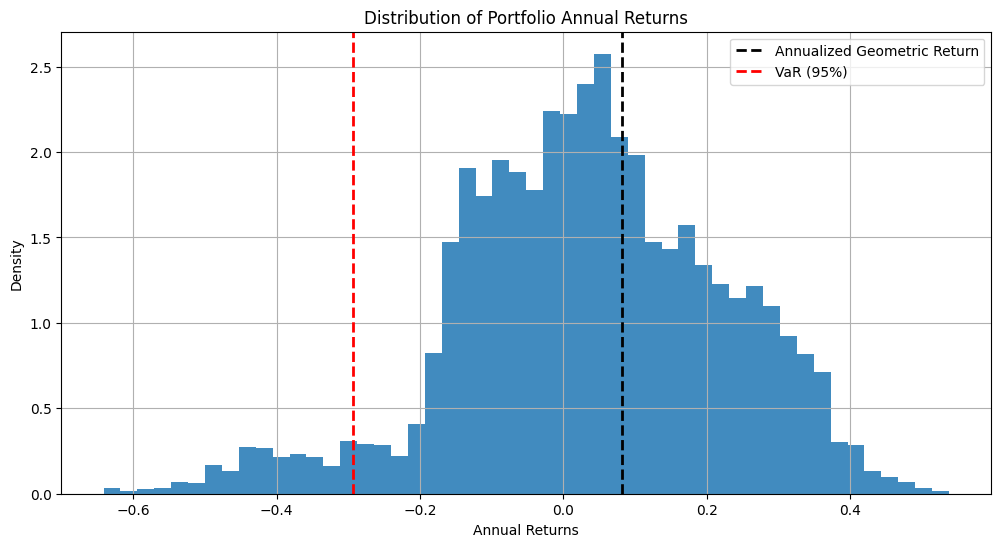

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(annual_returns, bins=50, density=True, alpha=0.85)
plt.axvline(portf_annualized_geometric_return, color='black', linestyle='dashed', 
            linewidth=2, label='Annualized Geometric Return')
plt.axvline(-annual_var, color='red', linestyle='dashed', 
            linewidth=2, label=f'VaR ({CONFIDENCE_LEVEL:.0%})')
plt.xlabel('Annual Returns')
plt.ylabel('Density')
plt.title('Distribution of Portfolio Annual Returns')
plt.legend()
plt.grid(True)
plt.show()